# Read band data

In [10]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window # Untuk membaca window secara efisien

# Path ke file GeoTIFF
dem_file_path = '../DATA/LANDSAT_60/Thermal_RGB_Colo.tif'

# Jumlah piksel pertama yang ingin dibaca
N_PIXELS_TO_READ = 15

with rasterio.open(dem_file_path) as src:
    band_count = src.count
    
    # Langsung tentukan koordinat untuk N piksel pertama di baris pertama (baris ke-0)
    pixel_rows = np.array([0] * N_PIXELS_TO_READ)  # Semua dari baris ke-0
    pixel_cols = np.arange(N_PIXELS_TO_READ)      # Kolom 0, 1, ..., N_PIXELS_TO_READ-1
    
    # Membuat dictionary untuk menyimpan data.
    # Panggilan src.xy() akan error jika pixel_cols ada yang >= src.width.
    data = {
        'row': pixel_rows,
        'col': pixel_cols,
        'geometry': [src.xy(r_idx, c_idx) for r_idx, c_idx in zip(pixel_rows, pixel_cols)]
    }
    
    # Definisikan window untuk membaca N piksel pertama dari baris pertama.
    # Panggilan src.read() dengan window ini akan error jika N_PIXELS_TO_READ > src.width.
    read_window = Window(col_off=0, row_off=0, width=N_PIXELS_TO_READ, height=1)
    
    # Membaca setiap band hanya untuk window yang telah ditentukan.
    # Looping ini dibatasi oleh jumlah band.
    for band_idx in range(1, band_count + 1):
        band_data_subset = src.read(band_idx, window=read_window)
        # band_data_subset akan berbentuk (1, N_PIXELS_TO_READ)
        # flatten() akan mengubahnya menjadi array 1D dengan N_PIXELS_TO_READ elemen.
        data[f'band_{band_idx}'] = band_data_subset.flatten()
            
    # Membuat dataframe dari dictionary.
    # DataFrame akan memiliki N_PIXELS_TO_READ baris.
    tif_df = pd.DataFrame(data)

print(tif_df)

    row  col                                    geometry     band_1  band_2  \
0     0    0  (121.57857445767073, -0.14539232873474456)  20.917732  6926.0   
1     0    1  (121.57884395225597, -0.14539232873474456)  20.824516  6983.0   
2     0    2  (121.57911344684119, -0.14539232873474456)  20.810596  6832.0   
3     0    3  (121.57938294142643, -0.14539232873474456)  20.835640  6938.0   
4     0    4  (121.57965243601167, -0.14539232873474456)  20.923218  7069.5   
5     0    5  (121.57992193059691, -0.14539232873474456)  21.014889  7302.5   
6     0    6  (121.58019142518214, -0.14539232873474456)  20.926073  8015.0   
7     0    7  (121.58046091976738, -0.14539232873474456)  21.145487  8259.0   
8     0    8  (121.58073041435262, -0.14539232873474456)  21.023335  7179.0   
9     0    9  (121.58099990893784, -0.14539232873474456)  21.034445  7145.0   
10    0   10  (121.58126940352308, -0.14539232873474456)  20.814812  7057.0   
11    0   11  (121.58153889810832, -0.14539232873474

# Visualize Thermal

Menampilkan Thermal_RGB_Kie_Besi.tif


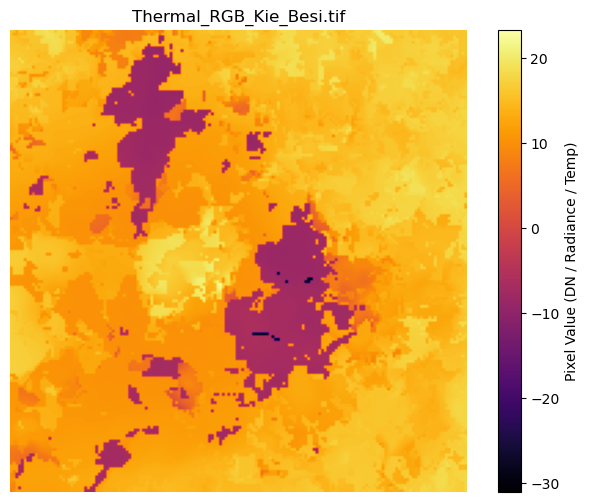

Menampilkan Thermal_RGB_Kie_Besi_2.tif


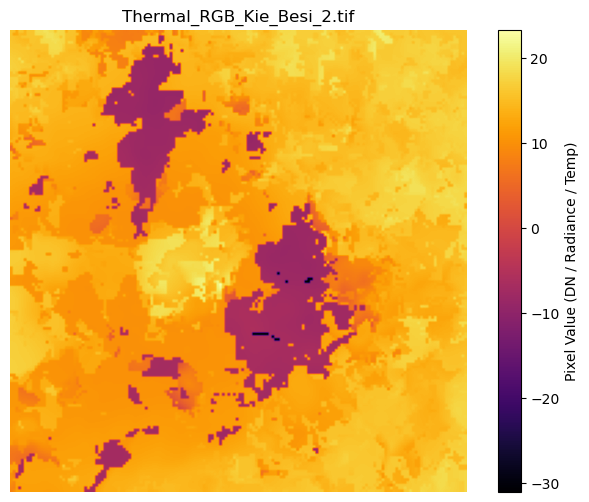

Menampilkan Thermal_RGB_Kie_Besi_3.tif


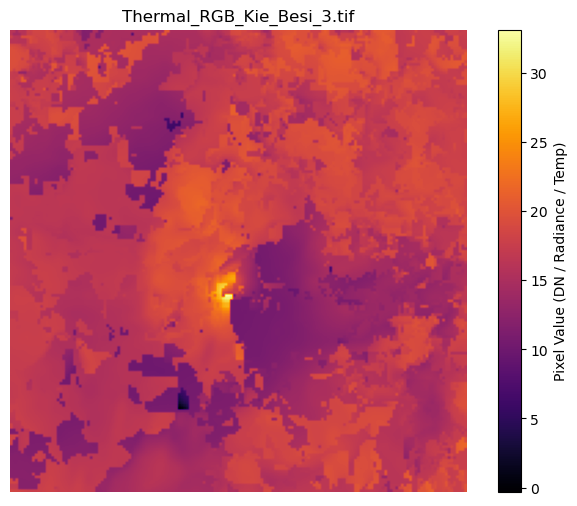

In [6]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path folder
thermal_folder_path = '../DATA/KIE BESI'

# Loop semua file .tif
for fname in os.listdir(thermal_folder_path):
    if fname.endswith('.tif'):
        fpath = os.path.join(thermal_folder_path, fname)
        print(f"Menampilkan {fname}")

        # Baca file GeoTIFF
        with rasterio.open(fpath) as src:
            img = src.read(1)  # ambil band pertama (karena thermal biasanya single band)

            # Mask nilai no data
            img = np.where(img == src.nodata, np.nan, img)

            # Tampilkan
            plt.figure(figsize=(8, 6))
            plt.imshow(img, cmap="inferno")
            plt.colorbar(label="Pixel Value (DN / Radiance / Temp)")
            plt.title(fname)
            plt.axis("off")
            plt.show()


# Viz Thermal + True Color

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Path folder input dan output
thermal_folder_path = '../DATA/LANDSAT_30_CF_2Y'
output_folder = 'Viz Thermal p30_2'
os.makedirs(output_folder, exist_ok=True)

# Buat colormap custom jadi sama kek GEE
gee_palette = ["#040274", "#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"]
gee_cmap = LinearSegmentedColormap.from_list("gee_cmap", gee_palette)

def stretch_band(band, low_pct=2, high_pct=98):
    valid = np.isfinite(band)
    if not np.any(valid):
        return np.zeros_like(band)
    p_low, p_high = np.nanpercentile(band[valid], (low_pct, high_pct))
    if p_high <= p_low:  # fallback
        p_low, p_high = np.nanmin(band[valid]), np.nanmax(band[valid])
    stretched = (band - p_low) / (p_high - p_low)
    stretched = np.clip(stretched, 0, 1)
    stretched[~valid] = 0
    return stretched

for tif in os.listdir(thermal_folder_path):
    tif_path = os.path.join(thermal_folder_path, tif)
    with rasterio.open(tif_path) as src:
        # Asumsi: Band 1 = thermal, Band 2 = red, Band 3 = green, Band 4 = blue
        thermal = src.read(1).astype(float)
        band4 = src.read(2).astype(float)  # red
        band3 = src.read(3).astype(float)  # green
        band2 = src.read(4).astype(float)  # blue

        nodata = src.nodata
        if nodata is not None:
            thermal = np.where(thermal == nodata, np.nan, thermal)
            band4 = np.where(band4 == nodata, np.nan, band4)
            band3 = np.where(band3 == nodata, np.nan, band3)
            band2 = np.where(band2 == nodata, np.nan, band2)

        # ==== True Color dengan stretch per band (biar ga pucat) ====
        r_s = stretch_band(band4, 2, 98)
        g_s = stretch_band(band3, 2, 98)
        b_s = stretch_band(band2, 2, 98)
        true_color = np.dstack((r_s, g_s, b_s))

        # ==== Thermal (pakai min/max dari data sendiri) ====
        thermal_min = np.nanmin(thermal)
        thermal_max = np.nanmax(thermal)
        thermal_disp = np.nan_to_num(thermal, nan=np.nan)

        # ==== Plotting ====
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Thermal dengan palette GEE
        im1 = axes[0].imshow(thermal_disp, cmap=gee_cmap, vmin=thermal_min, vmax=thermal_max)
        axes[0].set_title("Thermal")
        axes[0].axis("off")
        cbar = plt.colorbar(im1, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.04)
        cbar.set_label("Brightness Temperature")

        # True color (stretched)
        axes[1].imshow(true_color)
        axes[1].set_title("True Color")
        axes[1].axis("off")

        plt.suptitle(f"Visualisasi: {tif} p30")
        plt.tight_layout()

        out_path = os.path.join(output_folder, tif.replace('.tif', '.png'))
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
        plt.close(fig)


# Area Valid

In [5]:
import os
import glob
import rasterio
import numpy as np
import pandas as pd

thermal_folder_path = '../DATA/LANDSAT_30_3Y'

def calculate_valid_area_percentage_landsat(folder_path):
    """
    Hitung persentase area valid untuk semua file Landsat di folder.
    """
    results = []
    thermal_files = glob.glob(os.path.join(folder_path, '*.tif'))
    
    for file in thermal_files:
        with rasterio.open(file) as src:
            image = src.read(1)  # ambil band pertama (thermal)
            total_pixels = image.shape[0] * image.shape[1]
            valid_pixels = np.sum(image > 0)  # pixel > 0 dianggap valid
            valid_percentage = (valid_pixels / total_pixels) * 100
            fname = os.path.basename(file).replace(".tif", "")
            results.append([fname, valid_percentage])
    
    df = pd.DataFrame(results, columns=["Nama File", "Persentase Area Valid (%)"])
    return df

# Jalankan
df_hasil = calculate_valid_area_percentage_landsat(thermal_folder_path)

# Sortir biar jelas
print(df_hasil.sort_values(by="Persentase Area Valid (%)").to_string(index=False))

# Hitung rata-rata
avg_valid = df_hasil["Persentase Area Valid (%)"].mean()
print(f"\nRata-rata area valid untuk Landsat: {avg_valid:.2f}%")


                   Nama File  Persentase Area Valid (%)
        Thermal_RGB_Kie_Besi                  88.683305
      Thermal_RGB_Kie_Besi_2                  88.683305
          Thermal_RGB_Marapi                  94.459691
      Thermal_RGB_Galunggung                  96.038043
           Thermal_RGB_Salak                  96.581339
            Thermal_RGB_Gede                  98.583168
           Thermal_RGB_Dempo                  98.848984
          Thermal_RGB_Dukono                  99.175806
        Thermal_RGB_Lamongan                  99.300699
            Thermal_RGB_Colo                  99.509804
           Thermal_RGB_Kelud                  99.530516
          Thermal_RGB_Slamet                  99.645049
         Thermal_RGB_Ciremai                  99.680560
        Thermal_RGB_Tandikat                  99.697487
         Thermal_RGB_Kerinci                  99.819350
 Thermal_RGB_Arjuno_Welirang                  99.938418
        Thermal_RGB_Gamalama                  99